# Sentiment analysis for tweeter dataset using RNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Library

In [ ]:
import numpy as np
import pandas as pd
import re
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import random
from seaborn import countplot
from matplotlib import pyplot
import seaborn as sns

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameter

In [ ]:
# Hyper-parameters
input_size = 50
hidden_size = 128
num_layers = 3
num_classes = 2
batch_size = 100
num_epochs = 30
learning_rate = 0.001

# Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes):
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i in range (cm.shape[0]):
    for j in range (cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')

# Read Dataframe

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/soft computing assignment 3/Dataset 1.csv', encoding = "ISO-8859-1")
random.seed(42)
df = df.sample(frac = 1)

df.head(15)

,message,label
9212,thanks http://newsweek.comÃÂ for helping br...,1
2166,Hello to all my new followers,0
2911,"@rosiebunny No trust me, it'll work for every...",0
7728,Graphs of your Etsy Shop Sales - coming soon t...,0
7820,"@mydc no, it'll lay eggs in ur mom",0
9213,Gonna weight myself to fall into deeper depres...,1
769,"@LeNuage it's nice to meet u, i'm from to Chil...",0
2435,Watching http://bit.ly/16Mm0H about #google #...,0
8649,From Medium: Atlanta and the Unfolding of Pape...,1
8983,Spreading awareness about depression and shari...,1


# Data Visualisation

0 =  8000 
1 =  2314


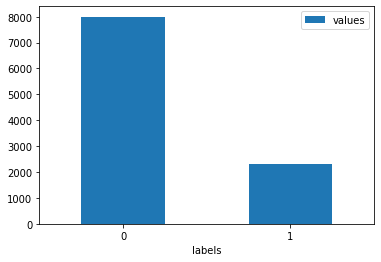

In [ ]:
label_count = df.label.value_counts()
label_0 = label_count[0]
label_1 = label_count[1]
print('0 = ',label_0, '\n1 = ', label_1)


grph = pd.DataFrame({'labels':['0', '1'], 'values':label_count})
ax = grph.plot.bar(x='labels', y='values', rot=0)

# Data Preprocessing

## Converting Lowercase

In [ ]:
#CONVERTING TO LOWERCASE
df['message'] = df['message'].str.lower()
df

,message,label
9212,thanks http://newsweek.comãâ for helping br...,1
2166,hello to all my new followers,0
2911,"@rosiebunny no trust me, it'll work for every...",0
7728,graphs of your etsy shop sales - coming soon t...,0
7820,"@mydc no, it'll lay eggs in ur mom",0
...,...,...
2249,@ednarheiner ill be happy to tweet with ya as ...,0
2456,student assignment reviews - done! phew... now...,0
10211,deepika padukone raises a toast to those who s...,1
127,happy gilmore is on,0


## Stopword Remove

In [ ]:
#REMOVING THE STOP WORDS
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
df['message'] = df['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,message,label
9212,thanks http://newsweek.comãâ helping bring li...,1
2166,hello new followers,0
2911,"@rosiebunny trust me, it'll work everyone else...",0
7728,graphs etsy shop sales - coming soon yaami.com...,0
7820,"@mydc no, it'll lay eggs ur mom",0
...,...,...
2249,@ednarheiner ill happy tweet ya well &quot;twe...,0
2456,student assignment reviews - done! phew... ont...,0
10211,deepika padukone raises toast survived depress...,1
127,happy gilmore,0


## Mention Remove

In [ ]:
def remove_Mention(s):
    s = re.sub(r'@[\S]+', ' ', s)
    return s
df['message'] = df['message'].apply(lambda text: remove_Mention(text))
df

,message,label
9212,thanks http://newsweek.comãâ helping bring li...,1
2166,hello new followers,0
2911,"trust me, it'll work everyone else...just me..",0
7728,graphs etsy shop sales - coming soon yaami.com...,0
7820,"no, it'll lay eggs ur mom",0
...,...,...
2249,ill happy tweet ya well &quot;tweet tweet&qu...,0
2456,student assignment reviews - done! phew... ont...,0
10211,deepika padukone raises toast survived depress...,1
127,happy gilmore,0


## URL Remove

In [ ]:
#REMOVING URL
def remove_URL(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
df['message'] = df['message'].apply(lambda text: remove_URL(text))
df

,message,label
9212,thanks helping bring light huge problem. chil...,1
2166,hello new followers,0
2911,"trust me, it'll work everyone else...just me..",0
7728,graphs etsy shop sales - coming soon yaami.com...,0
7820,"no, it'll lay eggs ur mom",0
...,...,...
2249,ill happy tweet ya well &quot;tweet tweet&qu...,0
2456,student assignment reviews - done! phew... ont...,0
10211,deepika padukone raises toast survived depress...,1
127,happy gilmore,0


## Number Remove

In [ ]:
def remove_Number(s):
    s = ''.join(c for c in s if not c.isdigit())
    return s
df['message'] = df['message'].apply(lambda text: remove_Number(text))
df

,message,label
9212,thanks helping bring light huge problem. chil...,1
2166,hello new followers,0
2911,"trust me, it'll work everyone else...just me..",0
7728,graphs etsy shop sales - coming soon yaami.com...,0
7820,"no, it'll lay eggs ur mom",0
...,...,...
2249,ill happy tweet ya well &quot;tweet tweet&qu...,0
2456,student assignment reviews - done! phew... ont...,0
10211,deepika padukone raises toast survived depress...,1
127,happy gilmore,0


## Hashtag Remove

In [ ]:
def rmove_Hastag(s):
    s = re.sub("#[A-Za-z0-9_]+","", s)
    return s
df['message'] = df['message'].apply(lambda text: rmove_Hastag(text))
df

,message,label
9212,thanks helping bring light huge problem. chil...,1
2166,hello new followers,0
2911,"trust me, it'll work everyone else...just me..",0
7728,graphs etsy shop sales - coming soon yaami.com...,0
7820,"no, it'll lay eggs ur mom",0
...,...,...
2249,ill happy tweet ya well &quot;tweet tweet&qu...,0
2456,student assignment reviews - done! phew... ont...,0
10211,deepika padukone raises toast survived depress...,1
127,happy gilmore,0


## Punctuation Remove

In [ ]:
#REMOVING PUNCTUATIONS
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '') 
    return text
df['message'] = df['message'].apply(remove_punctuations)
df

,message,label
9212,thanks helping bring light huge problem child...,1
2166,hello new followers,0
2911,trust me itll work everyone elsejust me,0
7728,graphs etsy shop sales coming soon yaamicom d...,0
7820,no itll lay eggs ur mom,0
...,...,...
2249,ill happy tweet ya well quottweet tweetquot lol,0
2456,student assignment reviews done phew onto con...,0
10211,deepika padukone raises toast survived depress...,1
127,happy gilmore,0


## Stemming

In [ ]:
#STEMMING
from nltk.stem.porter import PorterStemmer 

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df['message'] = df['message'].apply(lambda text: stem_words(text))
df

,message,label
9212,thank help bring light huge problem childhood ...,1
2166,hello new follow,0
2911,trust me itll work everyon elsejust me,0
7728,graph etsi shop sale come soon yaamicom detail...,0
7820,no itll lay egg ur mom,0
...,...,...
2249,ill happi tweet ya well quottweet tweetquot lol,0
2456,student assign review done phew onto confer pa...,0
10211,deepika padukon rais toast surviv depress ani ...,1
127,happi gilmor,0


## Empty Row Remove

In [ ]:
df['message'].replace('', np.nan, inplace=True)

In [ ]:
df

,message,label
9212,thank help bring light huge problem childhood ...,1
2166,hello new follow,0
2911,trust me itll work everyon elsejust me,0
7728,graph etsi shop sale come soon yaamicom detail...,0
7820,no itll lay egg ur mom,0
...,...,...
2249,ill happi tweet ya well quottweet tweetquot lol,0
2456,student assign review done phew onto confer pa...,0
10211,deepika padukon rais toast surviv depress ani ...,1
127,happi gilmor,0


In [ ]:
df.dropna(subset=['message'], inplace=True)

In [ ]:
df

,message,label
9212,thank help bring light huge problem childhood ...,1
2166,hello new follow,0
2911,trust me itll work everyon elsejust me,0
7728,graph etsi shop sale come soon yaamicom detail...,0
7820,no itll lay egg ur mom,0
...,...,...
2249,ill happi tweet ya well quottweet tweetquot lol,0
2456,student assign review done phew onto confer pa...,0
10211,deepika padukon rais toast surviv depress ani ...,1
127,happi gilmor,0


## Tokenize Message

In [ ]:
tknzr = TweetTokenizer(strip_handles=True)
def tweet_tokenizer(text):
    return tknzr.tokenize(text)
df['message'] = df['message'].apply(tweet_tokenizer)

In [ ]:
df

,message,label
9212,"[thank, help, bring, light, huge, problem, chi...",1
2166,"[hello, new, follow]",0
2911,"[trust, me, itll, work, everyon, elsejust, me]",0
7728,"[graph, etsi, shop, sale, come, soon, yaamicom...",0
7820,"[no, itll, lay, egg, ur, mom]",0
...,...,...
2249,"[ill, happi, tweet, ya, well, quottweet, tweet...",0
2456,"[student, assign, review, done, phew, onto, co...",0
10211,"[deepika, padukon, rais, toast, surviv, depres...",1
127,"[happi, gilmor]",0


# Train Test Split

In [ ]:
train, test = train_test_split(df,test_size=0.2, random_state=42)
train, valid = train_test_split(train,test_size=0.2, random_state=42)

# Glove Load

In [ ]:
# The first time you run this will download a ~823MB file
glove = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=20000)

.vector_cache/glove.6B.zip: 862MB [02:42, 5.30MB/s]                           
100%|█████████▉| 19999/20000 [00:00<00:00, 25739.68it/s]


# Making Data Loader

In [ ]:
def get_tweet_vectors(glove_vector, dataframe):
  vectorList = []
  for index, row in dataframe.iterrows():
    tweet = row['message']
    vector_sum = sum(glove_vector[w] for w in tweet)
    label = row['label']
    vectorList.append((vector_sum, label))
  return vectorList

In [ ]:
train = get_tweet_vectors(glove, train)
test = get_tweet_vectors(glove, test)
valid = get_tweet_vectors(glove, valid)

train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size, shuffle=False)

# Three Recurrent Layer RNN

### Step #1 : Design model using class

In [ ]:
#credit : https://github.com/yunjey/pytorch-tutorial/

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = RNN(input_size, hidden_size, num_layers, num_classes)

# To enable GPU
model.to(device)

RNN(
  (rnn): RNN(50, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

### Step #2 : Construct loss and optimizer

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Step #3 : Training: forward, loss, backward, step

In [ ]:
iteration_loss = []
for epoch in range(num_epochs):
  for i, (messages, labels) in enumerate(train_loader):
    messages = messages.unsqueeze(-2).to(device)
    labels = labels.to(device)
    model.zero_grad()
    output = model(messages)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
  if epoch % 5 == 4:
    # For Testing Data
    # Calculate Accuracy         
    correct = 0
    total = 0
    # Iterate through dataset
    for i, (messages, labels) in enumerate(test_loader):
      messages = messages.unsqueeze(-2).to(device)

      # Forward pass only to get logits/output
      output = model(messages)

      # Get predictions from the maximum value
      _, predicted = torch.max(output, 1)

      # Total number of labels
      total += labels.size(0)

      # Total correct predictions
      if torch.cuda.is_available():
        correct += (predicted.cpu() == labels.cpu()).sum() 
      else:
        correct += (predicted == labels).sum()

    if epoch>25 and  loss.item()> iteration_loss[-1]:
      break
    iteration_loss.append(loss.item())
    test_accuracy = 100 * correct.item() / total
    # For Validating Data
    # Calculate Accuracy         
    correct = 0
    total = 0
    # Iterate through dataset
    for i, (messages, labels) in enumerate(valid_loader):
      messages = messages.unsqueeze(-2).to(device)

      # Forward pass only to get logits/output
      output = model(messages)

      # Get predictions from the maximum value
      _, predicted = torch.max(output, 1)

      # Total number of labels
      total += labels.size(0)

      # Total correct predictions
      if torch.cuda.is_available():
        correct += (predicted.cpu() == labels.cpu()).sum() 
      else:
        correct += (predicted == labels).sum()

    validation_accuracy = 100 * correct.item() / total
    # Print Loss
    print('Epoch: {}. Loss: {}. Testing Accuracy: {}. Validation Accuracy: {}'.format(epoch+1, iteration_loss[-1], test_accuracy, validation_accuracy))

Epoch: 5. Loss: 0.3599979281425476. Testing Accuracy: 85.16536964980544. Validation Accuracy: 86.32218844984803
Epoch: 10. Loss: 0.2913890779018402. Testing Accuracy: 85.21400778210116. Validation Accuracy: 86.56534954407294
Epoch: 15. Loss: 0.2884097099304199. Testing Accuracy: 85.16536964980544. Validation Accuracy: 86.74772036474164
Epoch: 20. Loss: 0.13477368652820587. Testing Accuracy: 84.87354085603113. Validation Accuracy: 86.44376899696049
Epoch: 25. Loss: 0.28359732031822205. Testing Accuracy: 85.3112840466926. Validation Accuracy: 85.8966565349544
Epoch: 30. Loss: 0.2717471122741699. Testing Accuracy: 84.53307392996109. Validation Accuracy: 86.0790273556231


### Iteration Vs Loss

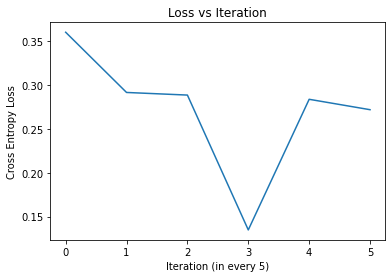

In [ ]:
plt.title("Loss vs Iteration")
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 5)')
plt.show()

In [ ]:
def get_all_prediction(loader):
  predictions_list = torch.tensor([], dtype=torch.int32)
  labels_list = torch.tensor([], dtype=torch.int32)
  for i, (messages, labels) in enumerate(loader):
    messages = messages.unsqueeze(-2).to(device)

    # Forward pass only to get logits/output
    outputs = model(messages)

    # Get predictions from the maximum value
    _, predictions = torch.max(outputs, 1)
    predictions_list = torch.cat((predictions_list, predictions.cpu()), dim = 0)
    labels_list = torch.cat((labels_list.cpu(), labels.cpu()), dim = 0).to(device)
  return predictions_list, labels_list.cpu()

Accuracy: 84.53307392996109
Precision: 84.53307392996109
Recall: 84.53307392996109
F1 score: 84.53307392996109


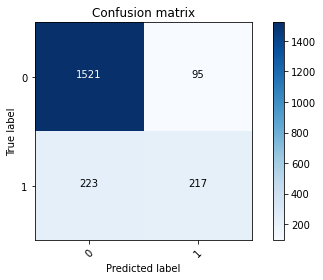

In [ ]:
y_pred, y_true = get_all_prediction(test_loader)
print('Accuracy: ' +str(accuracy_score(y_true, y_pred) * 100))
print('Precision: ' +str(precision_score(y_true, y_pred, average='micro') * 100))
print('Recall: ' +str(recall_score(y_true, y_pred, average='micro') * 100))
print('F1 score: ' +str(f1_score(y_true, y_pred, average='micro')  * 100))
confusion_mtx = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_mtx, classes = range(2))

# Prediction

In [ ]:
root_path = "/content/drive/MyDrive/Colab Notebooks/soft computing assignment 3/"
torch.save(model.state_dict(), root_path + 'RNN.pkl')

In [ ]:
model.load_state_dict(torch.load(root_path + 'RNN.pkl'))

<All keys matched successfully>

In [ ]:
def predict_sentiment(messages):
  messages = sum(glove[w] for w in messages)
  messages = messages.reshape(1, 1, 50).to(device)
  output = model(messages)
  _, predicted = torch.max(output, 1)
  if predicted > 0.5:
    print('Positive sentiment')
  else:
    print('Negative sentiment')

In [ ]:
test_text = input()
predict_sentiment(test_text)

I am happy
Positive sentiment
